#### ARIMA

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

AR(P): Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

I(d): Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

MA(q): Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Important Libraries

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(7,4), 'figure.dpi':80})
import warnings 
warnings.filterwarnings('ignore')

Importing the dataset

In [ ]:
df=pd.read_csv('Electric_Production.csv')
df.head()

,DATE,Value
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [ ]:
df.tail()

,DATE,Value
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212
396,1/1/2018,129.4048


In [ ]:
df.shape

(397, 2)

Makind the date varible index, and then transform it to pandas datetime 

In [ ]:
df.set_index('DATE',inplace=True)
df.index=pd.to_datetime(df.index)
#drop null values
df.dropna(inplace=True)
df.head()

,Value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


Plotting the whole time-series data

<AxesSubplot:xlabel='DATE'>

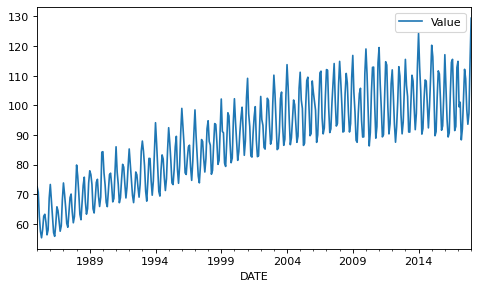

In [ ]:
df.plot()

ploting the first 30 months of electricity production to see the seasons present 

<AxesSubplot:xlabel='DATE'>

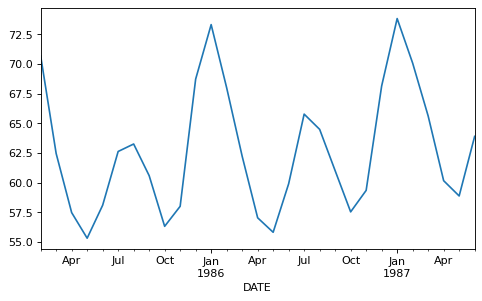

In [ ]:
df.Value[1:30].plot()

#### Important Libraries for time-series analysis

In [ ]:
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

#### Decompose the time-series to see the trend and seasonal components 

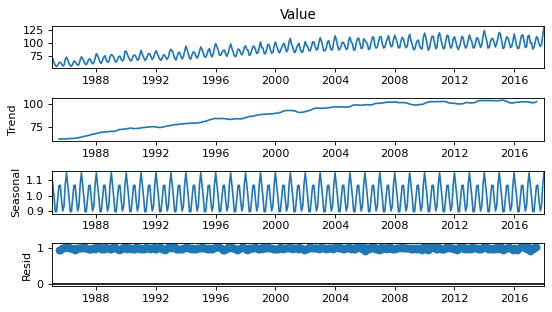

In [ ]:
result=seasonal_decompose(df['Value'],  model='multiplicable')
result.plot()
plt.show()

<AxesSubplot:xlabel='DATE'>

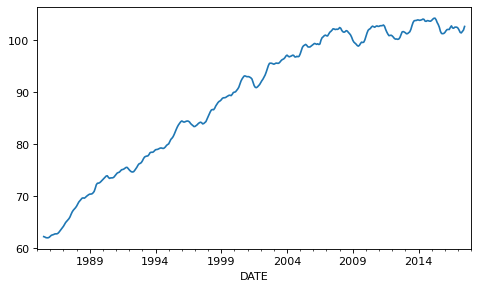

In [ ]:
result.trend.plot()

<AxesSubplot:xlabel='DATE'>

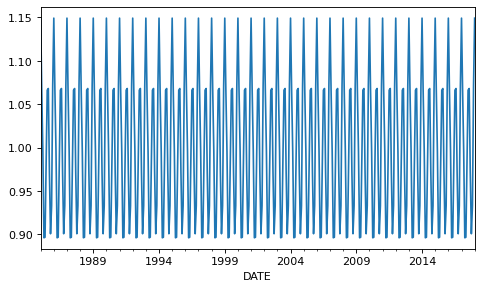

In [ ]:
result.seasonal.plot()

<AxesSubplot:xlabel='DATE'>

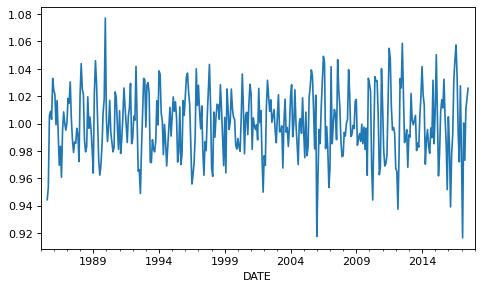

In [ ]:
result.resid.plot()

#### Exploring the TS data for stationarity aspect

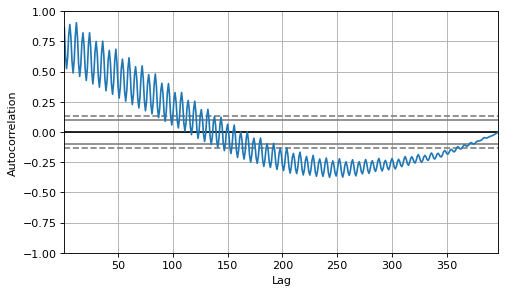

the data is non-stationary


In [ ]:
autocorrelation_plot(df)
plt.show()
print("the data is non-stationary")

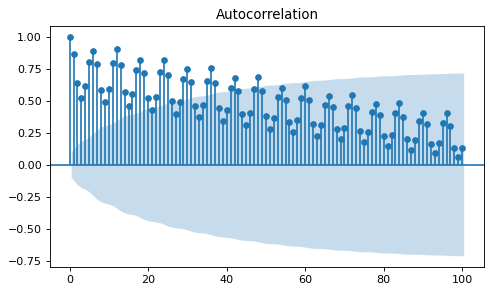

In [ ]:
plot_acf(df, lags=100)
plt.show()

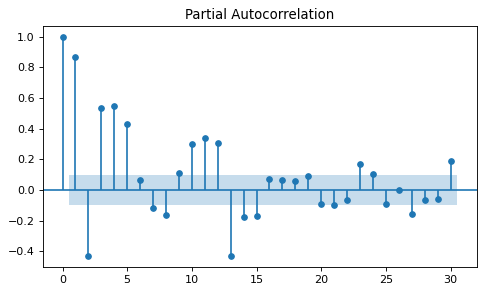

In [ ]:
plot_pacf(df, lags=30)
plt.show()

In [ ]:
result=adfuller(df['Value'])
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
for value,label in zip(result,labels):
    print(label+' : '+str(value))

if result[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("weak evidence against null hypothesis,indicating it is non-stationary ")

ADF Test Statistic : -2.2569903500472397
p-value : 0.18621469116586947
#Lags Used : 15
Number of Observations : 381
weak evidence against null hypothesis,indicating it is non-stationary 


#### Differentiating the data to make it stationary

In [ ]:
df['Value diff'] = df['Value'].diff()
df.head()

,Value,Value diff
DATE,,
1985-01-01,72.5052,NaN
1985-02-01,70.6720,-1.8332
1985-03-01,62.4502,-8.2218
1985-04-01,57.4714,-4.9788
1985-05-01,55.3151,-2.1563


In [ ]:
# Again testing if data is stationary
result=adfuller(df['Value diff'].dropna())
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
for value,label in zip(result,labels):
    print(label+' : '+str(value))

if result[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("weak evidence against null hypothesis,indicating it is non-stationary ")

ADF Test Statistic : -7.104890882267328
p-value : 4.077786565539053e-10
#Lags Used : 14
Number of Observations : 381
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


<AxesSubplot:xlabel='DATE'>

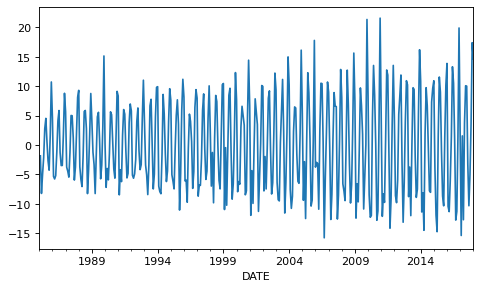

In [ ]:
df['Value diff'].plot()

#### Split The TS data into a training and a validation sets

In [ ]:
train = df[:int(0.65*(len(df)))]
valid = df[int(0.65*(len(df))):]

#### plotting the training and the validations sets on one graph

<AxesSubplot:xlabel='DATE'>

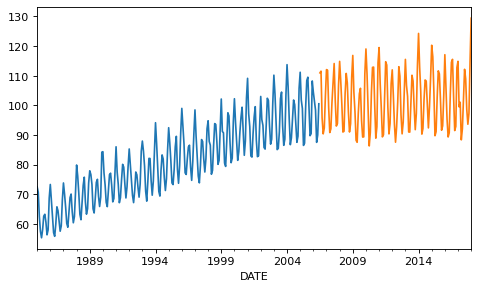

In [ ]:
train['Value'].plot()
valid['Value'].plot()

#### Libary for Auto ARIMA

In [ ]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from pmdarima.arima import AutoARIMA

#### building the arima  model without including seasonality factor

In [ ]:
arima_model = pm.auto_arima(train.Value)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  258
Model:               SARIMAX(1, 1, 5)   Log Likelihood                -721.094
Date:                Thu, 24 Jun 2021   AIC                           1458.187
Time:                        10:29:35   BIC                           1486.580
Sample:                             0   HQIC                          1469.605
                                - 258                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0994      0.026      3.788      0.000       0.048       0.151
ar.L1          0.3495      0.135      2.595      0.009       0.086       0.614
ma.L1         -0.4565      0.118     -3.859      0.000      -0.688      -0.225
ma.L2         -0.6579      0.068     -9.671      0.000      -0.791      -0.525
ma.L3         -0.3383      0.108     -3.130      0.002      -0.550      -0.126
ma.L4          0.0761      0.071      1.068      0.285      -0.064       0.216
ma.L5          0.4234      0.068      6.260      0.000       0.291       0.556
sigma2        15.7693      1.471     10.723      0.000      12.887      18.652
===================================================================================
Ljung-Box (L1) (Q):                   1.07   Jarque-Bera (JB):                 1.02
Prob(Q):                              0.30   Prob(JB):                         0.60
Heteroskedasticity (H):               2.07   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
forecasts = arima_model.predict(n_periods=valid.shape[0])
valid['forecasts'] = forecasts
valid.head()

,Value,Value diff,forecasts
DATE,,,
2006-07-01,110.9503,10.4259,108.295236
2006-08-01,111.5192,0.5689,107.902529
2006-09-01,95.7632,-15.7560,101.573940
2006-10-01,90.3738,-5.3894,98.985824
2006-11-01,92.3566,1.9828,100.148838


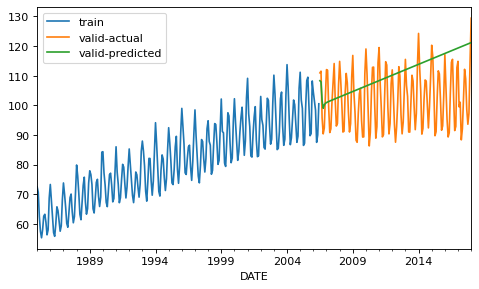

In [ ]:
train["Value"].plot()
valid["Value"].plot()
valid["forecasts"].plot()
labels = ['train', 'valid-actual', 'valid-predicted']
plt.legend(labels)

In [ ]:
MAE = mean_absolute_error(valid['Value'], valid.forecasts)
RMSE = math.sqrt(mean_squared_error(valid['Value'], valid.forecasts))

print("Mean Absolute Error: {:.3f}".format(MAE))
print("Root Mean Squared Error: {:.3f}".format(RMSE))

Mean Absolute Error: 11.350
Root Mean Squared Error: 13.777


#### MAPE

In [ ]:
valid['Error'] = np.abs(valid["Value"]-valid["forecasts"])
valid.head()

,Value,Value diff,forecasts,Error
DATE,,,,
2006-07-01,110.9503,10.4259,108.295236,2.655064
2006-08-01,111.5192,0.5689,107.902529,3.616671
2006-09-01,95.7632,-15.7560,101.573940,5.810740
2006-10-01,90.3738,-5.3894,98.985824,8.612024
2006-11-01,92.3566,1.9828,100.148838,7.792238


In [ ]:
Mape = np.mean(valid['Error']/valid['Value'])*100
print('Mean Absolute Percentage Error= {:.3f}%'.format(Mape))

Mean Absolute Percentage Error= 11.714%


#### Building ARIMA model with seasonality aspect

In [ ]:
arima_model_seasonal = pm.auto_arima(train['Value'], seasonal=True, m=6)
arima_model_seasonal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  258
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2], 6)   Log Likelihood                -558.463
Date:                                Thu, 24 Jun 2021   AIC                           1130.926
Time:                                        10:32:35   BIC                           1155.769
Sample:                                             0   HQIC                          1140.916
                                                - 258                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5373      0.066      8.147      0.000       0.408       0.667
ma.L1         -0.9776      0.026    -36.984      0.000      -1.029      -0.926
ar.S.L6        0.0067      0.008      0.849      0.396      -0.009       0.022
ar.S.L12       0.9899      0.008    127.002      0.000       0.975       1.005
ma.S.L6        0.0619      0.052      1.179      0.238      -0.041       0.165
ma.S.L12      -0.6988      0.063    -11.138      0.000      -0.822      -0.576
sigma2         4.0148      0.252     15.946      0.000       3.521       4.508
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                84.29
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.92   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Forecast using the arima seasonal

In [ ]:
forecasts = arima_model_seasonal.predict(n_periods=valid.shape[0])
valid['forecasts'] = forecasts
valid.head()

,Value,Value diff,forecasts,Error
DATE,,,,
2006-07-01,110.9503,10.4259,107.284784,2.655064
2006-08-01,111.5192,0.5689,107.723840,3.616671
2006-09-01,95.7632,-15.7560,98.858998,5.810740
2006-10-01,90.3738,-5.3894,91.296624,8.612024
2006-11-01,92.3566,1.9828,93.206973,7.792238


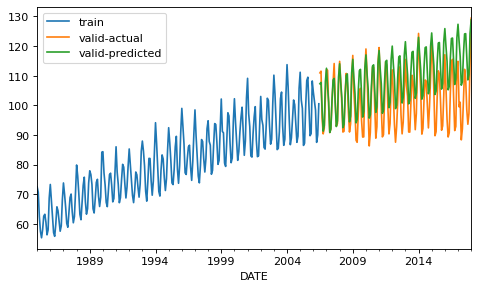

In [ ]:
train["Value"].plot()
valid["Value"].plot()
valid["forecasts"].plot()
labels = ['train', 'valid-actual', 'valid-predicted']
plt.legend(labels)

In [ ]:
MAE = mean_absolute_error(valid['Value'], valid.forecasts)
RMSE = math.sqrt(mean_squared_error(valid['Value'], valid.forecasts))

print("Mean Absolute Error: {:.3f}".format(MAE))
print("Root Mean Squared Error: {:.3f}".format(RMSE))

Mean Absolute Error: 7.502
Root Mean Squared Error: 9.055


#### MAPE

In [ ]:
valid['Error'] = np.abs(valid["Value"]-valid["forecasts"])
valid.head()

NameError: name 'np' is not defined

In [ ]:
Mape = np.mean(valid['Error']/valid['Value'])*100
print('Mean Absolute Percentage Error= {:.3f}%'.format(Mape))

Mean Absolute Percentage Error= 7.570%


In [ ]:
arima_model_seasonal_12 = pm.auto_arima(train['Value'], seasonal=True, m=12)
arima_model_seasonal_12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  258
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -524.037
Date:                              Thu, 24 Jun 2021   AIC                           1056.074
Time:                                      10:37:01   BIC                           1070.095
Sample:                                           0   HQIC                          1061.719
                                              - 258                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8374      0.117      7.174      0.000       0.609       1.066
ar.L1          0.5385      0.056      9.658      0.000       0.429       0.648
ma.S.L12      -0.6988      0.061    -11.482      0.000      -0.818      -0.580
sigma2         4.0089      0.232     17.274      0.000       3.554       4.464
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               116.57
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
forecasts = arima_model_seasonal_12.predict(n_periods=valid.shape[0])
valid['forecasts'] = forecasts
valid.head()

,Value,Value diff,forecasts,Error
DATE,,,,
2006-07-01,110.9503,10.4259,108.292630,3.665516
2006-08-01,111.5192,0.5689,108.750242,3.795360
2006-09-01,95.7632,-15.7560,99.570574,3.095798
2006-10-01,90.3738,-5.3894,92.266105,0.922824
2006-11-01,92.3566,1.9828,93.990653,0.850373


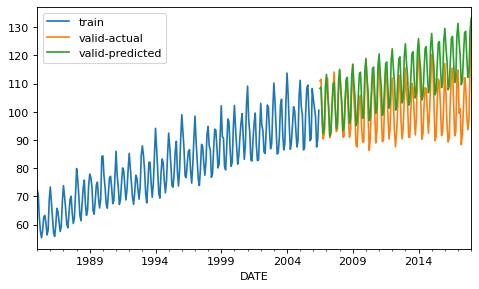

In [ ]:
train["Value"].plot()
valid["Value"].plot()
valid["forecasts"].plot()
labels = ['train', 'valid-actual', 'valid-predicted']
plt.legend(labels)

In [ ]:
MAE = mean_absolute_error(valid['Value'], valid.forecasts)
RMSE = math.sqrt(mean_squared_error(valid['Value'], valid.forecasts))

print("Mean Absolute Error: {:.3f}".format(MAE))
print("Root Mean Squared Error: {:.3f}".format(RMSE))

Mean Absolute Error: 9.417
Root Mean Squared Error: 11.140


#### MAPE

In [ ]:
valid['Error'] = np.abs(valid["Value"]-valid["forecasts"])
valid.head()

,Value,Value diff,forecasts,Error
DATE,,,,
2006-07-01,110.9503,10.4259,108.292630,2.657670
2006-08-01,111.5192,0.5689,108.750242,2.768958
2006-09-01,95.7632,-15.7560,99.570574,3.807374
2006-10-01,90.3738,-5.3894,92.266105,1.892305
2006-11-01,92.3566,1.9828,93.990653,1.634053


In [ ]:
Mape = np.mean(valid['Error']/valid['Value'])*100
print('Mean Absolute Percentage Error= {:.3f}%'.format(Mape))

Mean Absolute Percentage Error= 9.459%
